In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from timeit import default_timer
from tqdm import tqdm
from torch import optim
import matplotlib.pyplot as plt
import argparse
import yaml

from dataset import *
from model import *
from metrics import *
from utils import get_dataset, get_loader, get_model, train_model, test_model

In [54]:
def plot_depth(pred, target, lat, lon):
    """
    计算2018年9月每个深度的某个地点的真实及预测值，并绘图

    pred: torch.Size([5, 36, 54, 100])
    target: torch.Size([36, 54, 100])

    plot
    """
    pred = pred[:, :, lat, lon]
    target = target[:, lat, lon]  # [depth]

    depth = [   0,    5,   10,   15,   20,   25,   30,   35,   40,   45,   50,   55,
           60,   65,   70,   80,   90,  100,  125,  150,  175,  200,  225,  250,
          275,  300,  350,  400,  450,  500,  550,  600,  700,  800,  900, 1000]
    depth = [-x for x in depth]
    

    # Sample data for demonstration (replace this with actual data)
    clim = pred[0, :]
    fnn = pred[1, :]
    unet = pred[2, :]
    lstm = pred[3, :]
    earthformer = pred[4, :]
    truth = target
    

    # Create subplots
    fig, ax = plt.subplots(figsize=(6, 8))

    # Plotting all cases (replace with your actual data)
    # def plot_nitrate_profile(ax, title):
    ax.plot(clim, depth, label="climate", color='#a753a1')
    ax.plot(truth, depth, label="truth", linestyle='--', color='black')
    ax.plot(fnn, depth, label="FNN", color='#d5dca2')
    ax.plot(lstm, depth, label="LSTM", color='#86b47a')
    ax.plot(unet, depth, label="UNet", color='#736bba')
    ax.plot(earthformer, depth, label="Earthformer", color='#7edace')

    ax.legend()
    
    ax.set_xscale('log')
    ax.set_xlabel("Nitrate Concentration (mmol/m³)")
    ax.set_ylabel("Depth (m)")
    ax.set_title("(a)")

    ax.set_xlim([0.01, 1])
    ax.set_ylim([-1000, 0])
    ax.grid(True)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

## 测试FNN UNet

In [50]:
# 分割train val test
# FNN，seq_len = 0
# 按照年份分割数据

import yaml

config_file = './config/ST_Gulf_FNN.yaml'
with open(config_file, 'r') as f:
    args = yaml.safe_load(f)

train_data, test_data = get_dataset(args)
train_loader, val_loader, test_loader = get_loader(train_data, test_data, args)

device = torch.device('cpu')

print('len(train_loader): ', len(train_loader))
print('len(validate_loader)', len(val_loader))
print('len(test_loader)', len(test_loader))

Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/swh_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/oisst_monthly_201001-201904.nc


KeyboardInterrupt: 

In [ ]:
all_preds = []

# 气候态：取所有训练数据的平均值
print(train_data.label.shape)  # torch.Size([99, 36, 54, 100])
month_9 = torch.arange(8, 98, 12)  # 选取九月的indices
month_9_data = train_data.label[month_9, :, :, :]
print('九月份的数据： ',  month_9_data.shape)
clim = torch.mean(month_9_data, dim=0).to(device)  # 计算九月份的气候态
print('clim: ', clim.shape)
all_preds.append(clim)

# target
all_targets = test_data.label[6, ...]
print('targets: ', all_targets.shape)



torch.Size([99, 36, 54, 100])
九月份的数据：  torch.Size([8, 36, 54, 100])
clim:  torch.Size([36, 54, 100])
targets:  torch.Size([36, 54, 100])


In [ ]:
targets = test_data.label[5, ...]
depth, lat, lon = targets.shape

model = get_model(train_loader, args)
model = model.to(device)

preds, _ = test_model(model, test_loader, device, args, metric_names=['MSE', 'RMSE', 'MaxError',])

preds = torch.cat(preds, dim=0).squeeze(1)
print(preds.shape)
all_preds.append(preds[6, ...].reshape(depth, lat, lon))  # 10个月份，取第6个月份的预测结果（201809）

load FNN, in_dim=64800, out_dim=194400
Test mode, load checkpoint from /home/data2/pengguohang/My_Ocean/challenge/checkpoint/SS_Gulf_FNN-best.pt
average MSE: 0.055860087275505066
depth MSE: tensor([0.0529, 0.0538, 0.0544, 0.0804, 0.0495, 0.0548, 0.0568, 0.0506, 0.0428,
        0.0443, 0.0390, 0.0411, 0.0420, 0.0385, 0.0394, 0.0387, 0.0386, 0.0421,
        0.0475, 0.0784, 0.0804, 0.0568, 0.0594, 0.0460, 0.0433, 0.0445, 0.0396,
        0.0337, 0.0337, 0.0353, 0.2397, 0.0372, 0.0373, 0.0342, 0.1648, 0.0396])
seq_len MSE: tensor([0.0559])
average RMSE: 0.22862058877944946
depth RMSE: tensor([0.2301, 0.2320, 0.2332, 0.2836, 0.2225, 0.2340, 0.2383, 0.2249, 0.2068,
        0.2104, 0.1974, 0.2028, 0.2050, 0.1962, 0.1984, 0.1966, 0.1965, 0.2052,
        0.2178, 0.2800, 0.2836, 0.2383, 0.2437, 0.2146, 0.2081, 0.2109, 0.1991,
        0.1836, 0.1835, 0.1879, 0.4896, 0.1929, 0.1930, 0.1848, 0.4059, 0.1990])
seq_len RMSE: tensor([0.2286])
average MaxError: 0.8897066712379456
depth MaxError: tensor([

In [6]:
targets = test_data.label[5, ...]
depth, lat, lon = targets.shape

config_file = './config/ST_Gulf_UNET.yaml'
with open(config_file, 'r') as f:
    args = yaml.safe_load(f)

targets = test_data.label[5, ...]
depth, lat, lon = targets.shape

model = get_model(train_loader, args)
model = model.to(device)

preds, _ = test_model(model, test_loader, device, args, metric_names=['MSE', 'RMSE', 'MaxError',])

preds = torch.cat(preds, dim=0).squeeze(1)
print(preds.shape)
all_preds.append(preds[6, ...].reshape(depth, lat, lon))  # 10个月份，取第6个月份的预测结果（201809

load UNET, in_dim=12, out_dim=36
Test mode, load checkpoint from /home/data2/pengguohang/My_Ocean/challenge/checkpoint/SS_Gulf_UNET-best.pt
average MSE: 0.14272277057170868
depth MSE: tensor([0.0745, 0.1097, 0.3378, 0.4010, 0.1121, 0.0697, 0.0737, 0.1373, 0.0866,
        0.0737, 0.0503, 0.1246, 0.1215, 0.2314, 0.0446, 0.0367, 0.3935, 0.4490,
        0.1522, 0.0971, 0.0914, 0.1719, 0.0973, 0.0872, 0.1237, 0.1983, 0.1351,
        0.0493, 0.0410, 0.0470, 0.2452, 0.0877, 0.1381, 0.0862, 0.1535, 0.2084])
seq_len MSE: tensor([0.1427])
average RMSE: 0.3574560582637787
depth RMSE: tensor([0.2730, 0.3313, 0.5812, 0.6332, 0.3349, 0.2639, 0.2716, 0.3705, 0.2944,
        0.2715, 0.2244, 0.3529, 0.3486, 0.4810, 0.2111, 0.1915, 0.6273, 0.6701,
        0.3902, 0.3115, 0.3023, 0.4146, 0.3119, 0.2953, 0.3516, 0.4453, 0.3675,
        0.2220, 0.2025, 0.2167, 0.4951, 0.2961, 0.3716, 0.2935, 0.3918, 0.4565])
seq_len RMSE: tensor([0.3575])
average MaxError: 4.741979598999023
depth MaxError: tensor([1.0602, 

## 测试LSTM和Earthformer

In [7]:
import yaml

config_file = './config/ST_Gulf_LSTM.yaml'
with open(config_file, 'r') as f:
    args = yaml.safe_load(f)

train_data, test_data = get_dataset(args)
train_loader, val_loader, test_loader = get_loader(train_data, test_data, args)

print('len(train_loader): ', len(train_loader))
print('len(validate_loader)', len(val_loader))
print('len(test_loader)', len(test_loader))



Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/swh_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/oisst_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/uwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sla_monthly_201001_201901.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/adt_monthly_201001-201912.nc
shape of variable:  torch.Size([19, 5, 12, 54, 100]) torch.Size([19, 5, 36, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([36])
Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/peng

In [8]:
model = get_model(train_loader, args)
model = model.to(device)

preds, _ = test_model(model, test_loader, device, args, metric_names=['MSE', 'RMSE', 'MaxError',])


load LSTM, in_dim=64800, out_dim=194400
Test mode, load checkpoint from /home/data2/pengguohang/My_Ocean/challenge/checkpoint/SS_Gulf_LSTM-best.pt
average MSE: 0.08380935341119766
depth MSE: tensor([0.0981, 0.1180, 0.1163, 0.0959, 0.0753, 0.1013, 0.0898, 0.0893, 0.0937,
        0.0841, 0.0858, 0.1044, 0.0717, 0.0853, 0.0796, 0.0794, 0.0780, 0.0916,
        0.0951, 0.0917, 0.0921, 0.0953, 0.1034, 0.0837, 0.0830, 0.0741, 0.0675,
        0.0641, 0.0591, 0.0600, 0.0867, 0.0642, 0.0574, 0.0545, 0.0775, 0.0702])
seq_len MSE: tensor([0.0701, 0.0862, 0.0872, 0.0892, 0.0863])
average RMSE: 0.28676122426986694
depth RMSE: tensor([0.3121, 0.3352, 0.3363, 0.3086, 0.2737, 0.3174, 0.2991, 0.2984, 0.3058,
        0.2898, 0.2927, 0.3161, 0.2676, 0.2918, 0.2819, 0.2816, 0.2791, 0.3024,
        0.3082, 0.3027, 0.3034, 0.3083, 0.3182, 0.2891, 0.2878, 0.2720, 0.2596,
        0.2531, 0.2429, 0.2448, 0.2844, 0.2533, 0.2396, 0.2335, 0.2680, 0.2650])
seq_len RMSE: tensor([0.2644, 0.2902, 0.2927, 0.2960, 0.290

In [9]:
print(test_data.label.shape)

torch.Size([2, 5, 36, 54, 100])


In [10]:
targets = test_data.label[1, 0, ...]  # torch.Size([2, 5, 36, 54, 100])  10个月份，取第5个月份的真值
depth, lat, lon = targets.shape

preds = torch.cat(preds, dim=0)  

print(preds.shape)
all_preds.append(preds[1, 0, ...].reshape(depth, lat, lon))  # 10个月份，取第6个月份的预测结果（201809

torch.Size([2, 5, 36, 5400])


In [11]:
config_file = './config/ST_Gulf_Earthformer.yaml'
with open(config_file, 'r') as f:
    args = yaml.safe_load(f)

model = get_model(train_loader, args)
model = model.to(device)

preds, _ = test_model(model, test_loader, device, args, metric_names=['MSE', 'RMSE', 'MaxError',])

load Earthformer, in_dim=torch.Size([5, 54, 100, 12]), out_dim=torch.Size([5, 54, 100, 36])
Test mode, load checkpoint from /home/data2/pengguohang/My_Ocean/challenge/checkpoint/SS_Gulf_Earthformer-best.pt


/home/pengguohang/anaconda3/envs/py3.8/lib/python3.8/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


average MSE: 0.07759605348110199
depth MSE: tensor([0.1009, 0.1121, 0.1214, 0.0832, 0.0904, 0.0917, 0.0788, 0.0908, 0.0674,
        0.0853, 0.0844, 0.1276, 0.0628, 0.0663, 0.0751, 0.0827, 0.0686, 0.0771,
        0.0714, 0.0783, 0.0786, 0.0732, 0.0946, 0.0646, 0.0617, 0.0732, 0.0640,
        0.0707, 0.0470, 0.0474, 0.1066, 0.0723, 0.0471, 0.0456, 0.0701, 0.0601])
seq_len MSE: tensor([0.0682, 0.0805, 0.0809, 0.0796, 0.0789])
average RMSE: 0.2749808132648468
depth RMSE: tensor([0.3174, 0.3237, 0.3431, 0.2880, 0.3004, 0.3025, 0.2804, 0.3012, 0.2593,
        0.2920, 0.2905, 0.3509, 0.2505, 0.2574, 0.2740, 0.2874, 0.2616, 0.2774,
        0.2670, 0.2797, 0.2803, 0.2704, 0.3041, 0.2541, 0.2481, 0.2704, 0.2528,
        0.2657, 0.2168, 0.2177, 0.3159, 0.2689, 0.2171, 0.2136, 0.2539, 0.2451])
seq_len RMSE: tensor([0.2598, 0.2790, 0.2810, 0.2787, 0.2764])
average MaxError: 1.2911286354064941
depth MaxError: tensor([0.6126, 1.1735, 0.5971, 0.6464, 0.6083, 0.7021, 0.8552, 0.5963, 0.7731,
        0.6

In [12]:
targets = test_data.label[1, 0, ...]  # torch.Size([2, 5, 36, 54, 100])  10个月份，取第6个月份的真值
depth, lat, lon = targets.shape

preds = torch.cat(preds, dim=0)  

print(preds.shape)
all_preds.append(preds[1, 0, ...].reshape(depth, lat, lon)) 

torch.Size([2, 5, 36, 5400])


## 绘图

In [13]:
for i in range(len(all_preds)):
    print(all_preds[i].shape)

preds = torch.stack(all_preds, dim=0)
print(preds.shape)
print(all_targets.shape)

torch.Size([36, 54, 100])
torch.Size([36, 54, 100])
torch.Size([36, 54, 100])
torch.Size([36, 54, 100])
torch.Size([36, 54, 100])
torch.Size([5, 36, 54, 100])
torch.Size([36, 54, 100])


In [37]:
print(preds[0, ...].min())

tensor(0.)


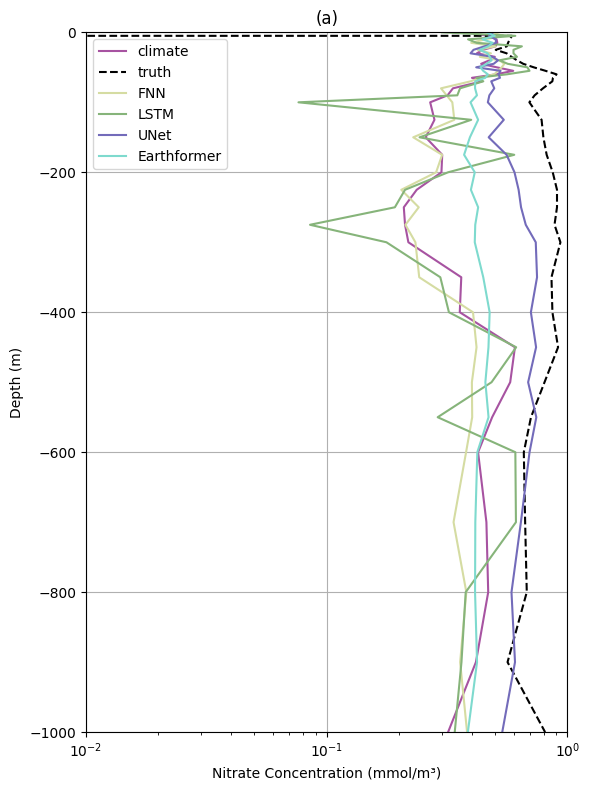

In [56]:
lat = 10
lon = 20
plot_depth(preds, all_targets, lat, lon)